In [0]:
!pip install tensorflow-gpu
!pip install konlpy

실행에 필요한 tensorflow와 konlpy를 설치합니다

In [0]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from string import punctuation
from collections import Counter
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import matplotlib.pyplot as plt

실행에 필요한 모듈들을 import합니다

In [0]:
okt = Okt()
counts = Counter()

In [0]:
df = pd.read_csv('good.csv',sep='\n')
df1 = pd.read_csv('bad.csv',sep='\n')

arr = np.array(df['review'])
arr1 = np.array(df1['review'])

label1 = np.ones(len(arr))
label2 = np.zeros(len(arr1))

data = np.concatenate([arr, arr1])
label = np.concatenate([label1, label2])

Pandas를 이용하여 Enter로 구분된 csv를 불러옵니다.
불러들인 두개의 DataFrame을 합쳐서 numpy배열의 데이터셋을 만듭니다.
0과1로 데이터 라벨링을 진행한 후 numpy배열의 label셋을 만듭니다.

In [0]:
shuffle_data = np.arange((data).shape[0])
np.random.shuffle(shuffle_data)

data = data[s]
label = label[s]

shuffle_data 배열에 data의 인덱스를 넣고 data와 label 배열을 동일한 순서로 섞어 데이터셋을 셔플합니다.

In [0]:
revised_reviews = [' '.join(okt.morphs(review)) for review in data]

한국어 자연어 처리 모듈인 konlpy의 Okt를 이용하여 형태소를 분리하여 데이터를 토큰화합니다.

In [0]:
for i,review in enumerate(revised_reviews):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    revised_reviews[i] = text
    counts.update(text.split())

단어를 분리한 후 각 단어의 빈도를 카운트합니다.

In [0]:
word_counts = sorted(counts, key=counts.get, reverse=True)
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

각 단어를 딕셔너리를 통해 정수로 변환합니다.

In [0]:
mapped_reviews = []

for review in revised_reviews:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

sequence_length = 300 
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

df = []

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    df.append(label[i])
    sequences[i, -len(row):] = review_arr[-sequence_length:]

총 길이가300인 시퀀스에 단어 인덱스를 대입합니다.
단어 인덱스의 길이가 300보다 작을 경우 남은 공간을 제로 패딩으로 채웁니다.


In [0]:
X_train = sequences[:20000, :]
y_train = np.array(df[:20000])
X_test = sequences[20000:, :]
y_test = np.array(df[20000:])

데이터셋을 학습 데이터셋과 테스트 셋으로 나눕니다.

In [0]:
n_words = len(word_to_int) + 1

In [18]:
model = models.Sequential()
model.add(layers.Embedding(n_words, 300, 
                           embeddings_regularizer='l2'))
model.add(layers.LSTM(16))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         9850200   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 9,870,505
Trainable params: 9,870,505
Non-trainable params: 0
_________________________________________________________________


학습을 진행할 LSTM모델을 구축합니다.

In [19]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

callback_list = [TensorBoard(),tf.keras.callbacks.ModelCheckpoint(filepath='Sentiment_Classification.h5', 
                                 monitor='val_loss', save_best_only=True),
                 tf.keras.callbacks.EarlyStopping(patience=5)]

history = model.fit(X_train, y_train, 
                    batch_size=4096, epochs=10, 
                    validation_split=0.2, callbacks=callback_list)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16000/16000 [==============================] - 71s 4ms/sample - loss: 75.9088 - acc: 0.5742 - val_loss: 64.6913 - val_acc: 0.6043
Epoch 2/10
16000/16000 [==============================] - 55s 3ms/sample - loss: 58.9550 - acc: 0.5984 - val_loss: 49.6433 - val_acc: 0.6018
Epoch 3/10
16000/16000 [==============================] - 49s 3ms/sample - loss: 44.9585 - acc: 0.5986 - val_loss: 37.4083 - val_acc: 0.6065
Epoch 4/10
16000/16000 [==============================] - 55s 3ms/sample - loss: 33.6678 - acc: 0.6007 - val_loss: 27.6824 - val_acc: 0.6108
Epoch 5/10
16000/16000 [==============================] - 46s 3ms/sample - loss: 24.7635 - acc: 0.6091 - val_loss: 20.1246 - val_acc: 0.6250
Epoch 6/10
16000/16000 [==============================] - 45s 3ms/sample - loss: 17.8972 - acc: 0.6271 - val_loss: 14.3795 - val_acc: 0.6428
Epoch 7/10
16000/16000 [==============================] - 45s 3ms/sample - loss: 12.7154 - acc: 0.6463 - val_loss: 10.1075 - val_acc: 0.6637
Epoch 8/10
16000/16000 [

학습할 데이터 셋을 할당한 후 손실 함수데이터 셋을 할당한 후 최적화를 위해 손실 함수와 하이퍼파라미터를 지정하고 10회 가량 반복학습을 진행합니다.

반복학습 중 가장 결과가 좋은 모델을 자동으로 저장합니다.

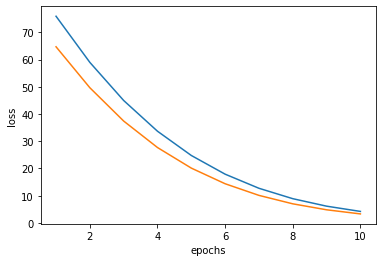

In [21]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

학습 중 기록된 손실률을 시각화 합니다.

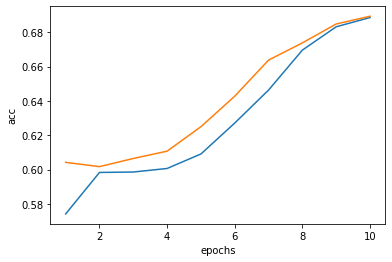

In [22]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

학습 중 기록된 정확도를 시각화 합니다.